In [1]:
import numpy as np
from glob import glob
import os
import gc
from pathlib import Path
import yaml

from matplotlib import pyplot as plt
from cycler import cycler
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('thesis')

from scipy.optimize import curve_fit
from scipy import stats

plt.rcParams.update({'figure.dpi': 150})
plt.rcParams.update({'axes.prop_cycle': cycler(color=['#5994cd', '#d74164', '#4eaa76', '#d88300', '#7365cf', \
                                                      '#c85e3e', '#83a23e', '#c851b1', '#1850a1'])})

from importlib import reload
import data_processing as dp

### Load the config file and add new parameters

In [2]:
data_path = '/Users/clarke/Documents/Research/Nanospheres/Data/'
base_path = '/Users/clarke/Data/gas_collisions/pulse_calibration/sphere_20251212/'
drive_path = '/Users/clarke/Data/'

if not os.path.exists(drive_path):
    print('Error: check that the external drive is plugged in!')

folders = glob(base_path + '*')

cal_datasets = {}

for folder in folders:
    # print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        # print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    cal_datasets[folder.split(base_path)[-1]] = sub_datasets

dataset_ind = 3
dataset = list(cal_datasets.keys())[dataset_ind]

with open(base_path + dataset + '/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config['calibrate'] = False

template = np.array(config['template'])
resolution = config['resolution']

for key in config.keys():
    print(key + ':\t ', config[key])

apply_notch:	  False
cal_factors:	  [1.657455591234279e+19, -27.568641081090938]
calibrate:	  False
f_cutoff:	  [25000.0, 100000.0]
fit_window:	  0.1
meters_per_volt:	  5.274524065920458e-08
resolution:	  124.77632804480102
search_window:	  5e-05
template:	  [0.0004129153319133956, 0.0008511766450450722, 0.0013008542239887962, 0.0017575910414643762, 0.0022174942296917044, 0.002677227254843185, 0.0031340245986604173, 0.0035857540987448825, 0.004030900758279428, 0.004468597416404031, 0.0048985781464921845, 0.005321180031762205, 0.005737270905720494, 0.006148228337885688, 0.006555848345337454, 0.00696230801502213, 0.007370060943155876, 0.0077817885447762246, 0.008200286870399488, 0.0086284113742073, 0.009068960446739025, 0.009524619813235323, 0.009997849784587644, 0.010490836940653392, 0.011005393045576753, 0.011542921808504164, 0.012104336585197426, 0.012690048249651989, 0.013299906378448148, 0.013933211584443583, 0.014588682271251959, 0.015264492364906719, 0.01595826347063225, 0.0166671

### List the background datasets

In [3]:
base_path = '/Users/clarke/Data/gas_collisions/background_data/sphere_20251212/'

folders = glob(base_path + '*')

bkg_datasets = {}

for folder in folders:
    print(folder.split(base_path)[-1])
    all_items = glob(folder + '/*')
    subfolders = np.unique(['_'.join(s.split('_')[:-1]) for s in all_items])
    sub_datasets = []
    for subfolder in subfolders:
        sub_datasets.append(subfolder.split(base_path)[-1].split('/')[-1])
        print('\t' + subfolder.split(base_path)[-1].split('/')[-1])
    bkg_datasets[folder.split(base_path)[-1]] = sub_datasets

20251216_unknown_6e-8mbar
	20251216_df
20251217_unknown_5e-8mbar_kryptonpumped
	20251217_df
20251216_unknown_5e-8mbar_cryopumped
	20251216_df
20251218_p8e_1e-7mbar_noinjection
	20251218_df
20251218_p8e_7e-8mbar_noinjection
	20251218_df
20251215_p8e_5e-8mbar
	20251215_df
20251216_unknown_6e-8mbar_cryopumped
	20251216_df


### Load a background dataset

In [54]:
reload(dp)

# choose which dataset to look at
dataset_ind = 0
dataset = list(bkg_datasets.keys())[dataset_ind]

plot = False

plot_path = 'figures/' + base_path.split(drive_path)[-1] + dataset + '/' + bkg_datasets[dataset][0] if plot else None
nd = dp.NanoDataset(base_path + dataset + '/' + bkg_datasets[dataset][0], plot_path, verbose=True, max_files=2, \
                    max_windows=[1000000, 20][int(plot)], config=config, quality_check_window=1e-2)
nd.load_search_data()
nd.save_to_hdf5()

Loading file 1...
    -> Computing force for window 10000 of 134213...
    -> Computing force for window 20000 of 134213...
    -> Computing force for window 30000 of 134213...
    -> Computing force for window 40000 of 134213...
    -> Computing force for window 50000 of 134213...
    -> Computing force for window 60000 of 134213...
    -> Computing force for window 70000 of 134213...
    -> Computing force for window 80000 of 134213...
    -> Computing force for window 90000 of 134213...
    -> Computing force for window 100000 of 134213...
    -> Computing force for window 110000 of 134213...
    -> Computing force for window 120000 of 134213...
    -> Computing force for window 130000 of 134213...
Loading file 2...
    -> Computing force for window 10000 of 134213...
    -> Computing force for window 20000 of 134213...
    -> Computing force for window 30000 of 134213...
    -> Computing force for window 40000 of 134213...
    -> Computing force for window 50000 of 134213...
    ->

In [56]:
nd2 = dp.NanoDataset('')
nd2.load_from_hdf5(base_path + dataset + '/' + bkg_datasets[dataset][0] + '_processed.hdf5')

In [57]:
nd2

### Cut away noisy periods

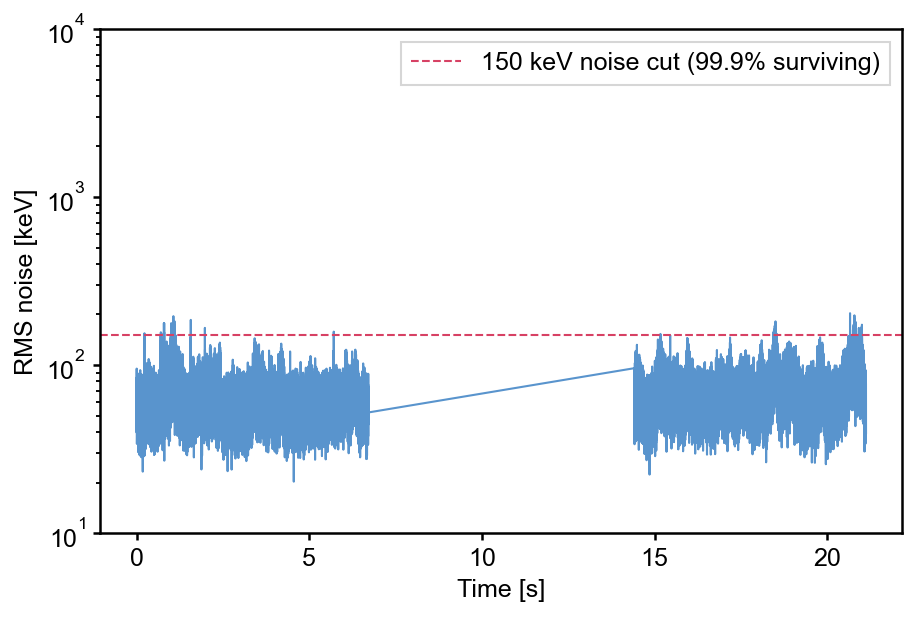

In [ ]:
noise_thresh = 150 # keV

noise_cut = (nd.impulse_rms < noise_thresh) & (nd.impulse_rms > 10)

# also cut based on the fit to the resonance
res_cut = nd.resonance_params[:, 2] < 2*np.pi*100

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.semilogy(nd.pulse_times, nd.impulse_rms)
ax.axhline(noise_thresh, ls='--', color='C1', label='{:.0f} keV noise cut ({:.1f}% surviving)'\
                                                    .format(noise_thresh, 100*sum(noise_cut)/len(noise_cut)))
ax.set_xlabel('Time [s]')
ax.set_ylabel('RMS noise [keV]')
ax.set_ylim([1e1, 1e4])
ax.legend(loc='upper right')

### Cut based on goodness of fit

In [ ]:
z_cut = 2
ndof = len(template) - 1
alpha = (1 - stats.norm.cdf(z_cut))*2

pvals = 1. - stats.chi2.cdf(nd.chi2, df=ndof)
chi2_cut = np.zeros(nd.chi2.shape, dtype=bool)
chi2_cut[pvals > alpha] = True

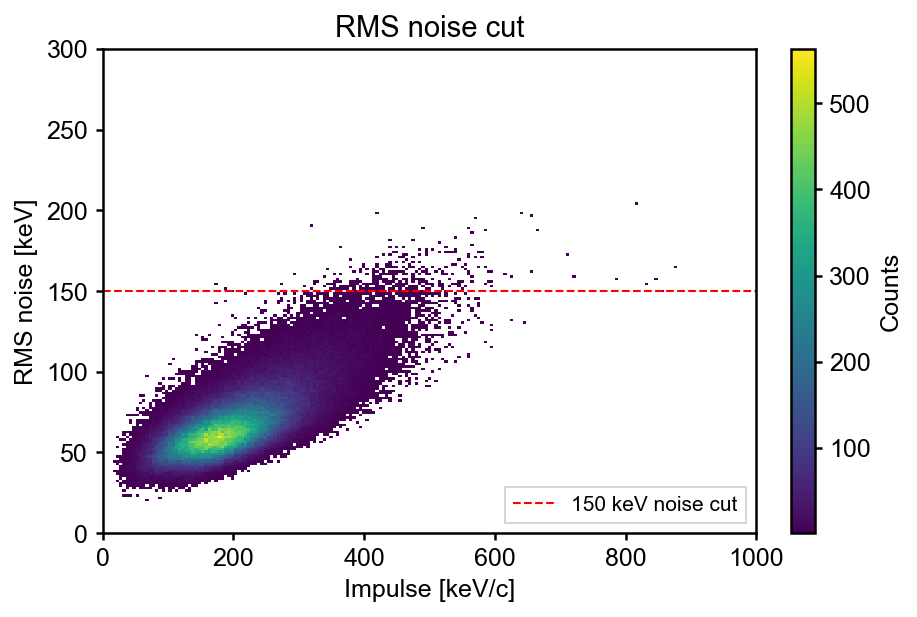

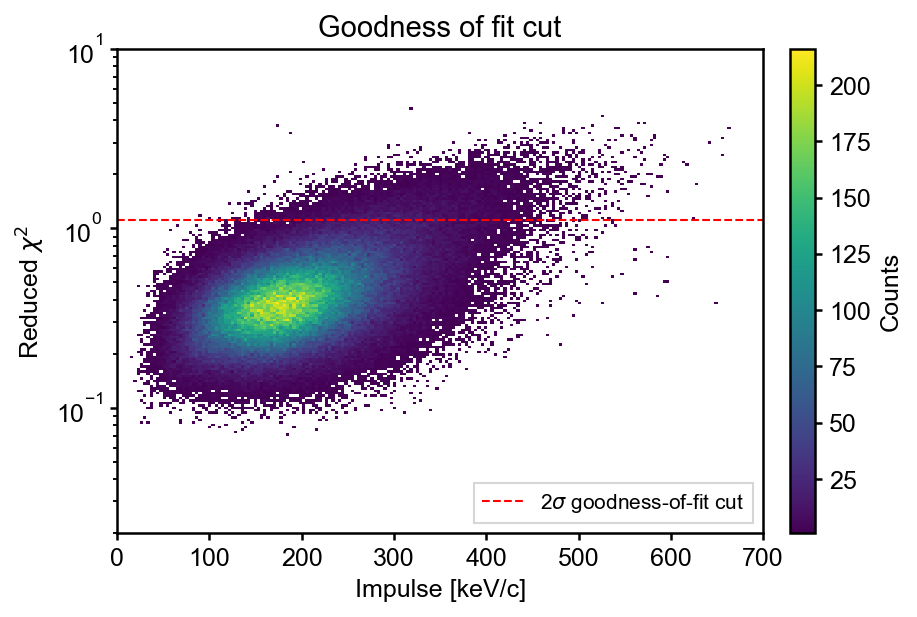

In [47]:
fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.linspace(0, 300, 200)
bins_x = np.linspace(0, 1000, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.impulse_rms, bins=(bins_x, bins_y), cmin=1, cmax=1e5)
ax.axhline(noise_thresh, ls='--', color='red', label='{:.0f} keV noise cut'.format(noise_thresh))
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('RMS noise [keV]')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('RMS noise cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
bins_y = np.logspace(np.log10(2e-2), 1, 200)
bins_x = np.linspace(0, 700, 200)
h = ax.hist2d(np.abs(nd.impulses), nd.chi2/ndof, bins=(bins_x, bins_y), cmin=1, cmax=1e5)
ax.axhline(stats.chi2.ppf(1 - alpha, ndof)/ndof, ls='--', color='red', label=r'{:.0f}$\sigma$ goodness-of-fit cut'.format(z_cut))
ax.set_yscale('log')
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel(r'Reduced $\chi^2$')
ax.legend(fontsize=10, loc='lower right')
ax.set_title('Goodness of fit cut')
fig.colorbar(h[3], ax=ax, label='Counts', pad=0.01)

### Histogram the results

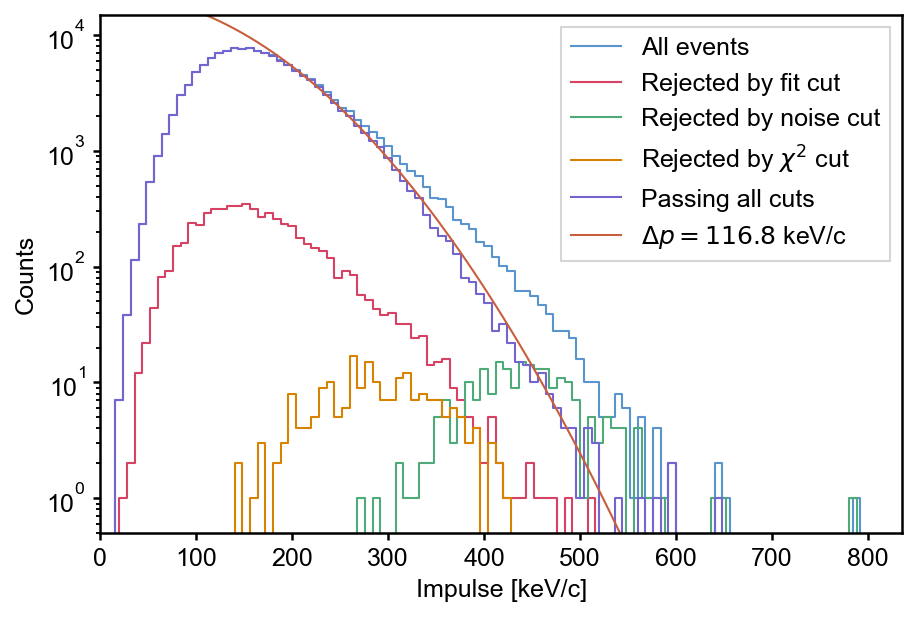

In [52]:
bin_edges = np.linspace(0, 800, 101)

counts_all, _ = np.histogram(nd.impulses, bins=bin_edges)
counts_acc, _ = np.histogram(nd.impulses[chi2_cut & noise_cut], bins=bin_edges)

bins = (bin_edges[1:] + bin_edges[:-1])/2.

ppb = len(nd.impulses)/len(bins)
exp = np.floor(np.log10(ppb))
coeff = 5*np.ceil(ppb/10**exp)

fit_ind = int(1.5*np.argmax(counts_all))

def half_gaus(x, A, sigma):
    return A*np.exp(-x**2/2/sigma**2)

p, _ = curve_fit(half_gaus, bins[fit_ind:], counts_acc[fit_ind:], p0=(ppb, np.std(nd.impulses[~np.isnan(nd.impulses)])))

fig, ax = plt.subplots(figsize=(6, 4), layout='constrained')
ax.step(bins, counts_all, where='mid', label='All events')
ax.step(bins, np.histogram(nd.impulses[~res_cut], bins=bin_edges)[0], label='Rejected by fit cut')
ax.step(bins, np.histogram(nd.impulses[~noise_cut & res_cut], bins=bin_edges)[0], label='Rejected by noise cut')
ax.step(bins, np.histogram(nd.impulses[~chi2_cut & noise_cut & ~res_cut], bins=bin_edges)[0], label=r'Rejected by $\chi^2$ cut')
ax.step(bins, counts_acc, where='mid', label='Passing all cuts')
ax.plot(bins, half_gaus(bins, *p), label='$\\Delta p={:.1f}$ keV/c'.format(np.abs(p[1])))
ax.set_xlim([0, 1.05*np.amax(bins)])
ax.set_ylim([5e-1, coeff*10**exp])
ax.set_xlabel('Impulse [keV/c]')
ax.set_ylabel('Counts')
ax.set_yscale('log')
ax.legend()

counts_bkg = np.copy(counts_acc)
imp_spec_bkg = np.copy(bins)